# EXERCISE 3 - ML - Grundverfahren

## 1.) Constrained Optimization (6 Points)

You are given the following Optimization problem:
\begin{align*}
    \underset{\boldsymbol{x}}{\textrm{ min }}& \boldsymbol{x}^T\boldsymbol{M}\boldsymbol{x} + \boldsymbol{x}^T \boldsymbol{h} \\
        s.t.          & \boldsymbol{x}^T \boldsymbol{b} \geq c,
\end{align*}
where $\boldsymbol{M}$ is a positive definit, symmetric Matrix. Note that vectors and matrices are boldsymbol, where Matrices have capital letters. <br>
Derive the optimal solution for $\boldsymbol{x} $ independant of the Lagrangian multiplier(s) (i.e. you have to solve for the dual). <br> <br>
Make sure that you mark vectors and matrices as a boldsymbol and small letters and capital letters respectively. Symbols which are not marked as boldsymbols will count as scalar. <br>
Take care of vector/matrix multiplication and derivatives. And make use of the properties of $\boldsymbol{M}$. Don't forget to look up matrix-vector calculus in the matrix cookbook, if you don't remember the rules. <br><br>


### Solution

\begin{align*}

\frac{\partial \boldsymbol{x}^T\boldsymbol{M}\boldsymbol{x} + \boldsymbol{x}^T\boldsymbol{h}}{\partial\boldsymbol{x}}

&= 2 \boldsymbol{M}\boldsymbol{x} + \boldsymbol{h}

\\\text{Setting the derivative to zero:}\\

0 &= \boldsymbol{M}\boldsymbol{x} + \boldsymbol{h} \\

- \boldsymbol{h} &= \boldsymbol{M}\boldsymbol{x} \\

\boldsymbol{x} &= \boldsymbol{M}^{-1} \boldsymbol{h} \\

\end{align*}

TODO: is this a minimum? is this how langrangian works?

### Solution with Lagrangian

Let $f(\boldsymbol{x}) := (\boldsymbol{x}^T\boldsymbol{M}\boldsymbol{x} + \boldsymbol{x}^T \boldsymbol{h})$.

Then $L(\boldsymbol{x},\alpha) := f(\boldsymbol{x}) - \alpha \cdot (\boldsymbol{x}^T \boldsymbol{b} - c)$.

Now formulate this optimization problem:
$\min_{\boldsymbol{x}} \max_{\alpha} L(\boldsymbol{x}, \alpha)$ s.t. $\alpha \geq 0$.

Computing derivatives:

$\nabla_\alpha L = \boldsymbol{x}^T \boldsymbol{b} - c$

$\nabla_\boldsymbol{x} L  = 2 \boldsymbol{M}\boldsymbol{x} + \boldsymbol{h}- \alpha \boldsymbol{b}$



## 2.) k-Means (7 Points)
Here we will implement one of the most basic appraoches to clustering - the k-Means algorithm. 
Let us start with some basic imports and implementing functionallity to visualize our results. 

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional

def visualize_2d_clustering(data_points: np.ndarray, assignments_one_hot: np.ndarray, centers: np.ndarray, k: int,
                            centers_history: Optional[np.ndarray] = None, title: Optional[str] = None):
    """Visualizes clusters, centers and path of centers"""
    plt.figure(figsize=(6, 6), dpi=100)
    assignments = np.argmax(assignments_one_hot, axis=1)

    for i in range(k):
        # get next color
        c = next(plt.gca()._get_lines.prop_cycler)['color']
        # get cluster
        cur_assignments = assignments == i
        # plot clusters
        plt.scatter(data_points[cur_assignments, 0], data_points[cur_assignments, 1], c=c, 
                    label="Cluster {:02d}".format(i))
        
        #plot history of centers if it is given
        if centers_history is not None:
            plt.scatter(centers_history[:, i, 0], centers_history[:, i, 1], marker="x", c=c)
            plt.plot(centers_history[:, i, 0], centers_history[:, i, 1], c=c)

    plt.scatter(centers[:, 0], centers[:, 1], label="Centers", color="black", marker="X")

    if title is not None:
        plt.title(title)

    plt.legend()

Next we going to implement the actual algorithm. As a quick reminder, K-Means works by iterating the following steps:

Start with k randomly picked centers

* 1.) Assign each point to the closest center
* 2.) Addjust centers by taking the average over all points assigned to it
 
Implementing them will be your task for this exericse

In [2]:
def assignment_step(data_points: np.ndarray, centers: np.ndarray) -> np.ndarray:
    """
    Assignment Step: Computes assignments to nearest cluster
    :param data_points: Data points to cluster  (shape: [N x data_dim])
    :param centers: current cluster centers (shape: [k, data_dim])
    :return Assignments (as one hot) (shape: [N, k])
    """
    N = data_points.shape[0]
    k = centers.shape[0]
    result = np.zeros((N,k))
    for idx_sample in range(N):
        sample = data_points[idx_sample]
        dists = [np.dot(centers[i]-sample,centers[i]-sample) for i in range(k)]
        next_center = np.argmin(dists)
        result[idx_sample,next_center] = 1
    return result


def adjustment_step(data_points: np.ndarray, assignments_one_hot: np.ndarray) -> np.ndarray:
    """
    Adjustment Step: Adjust centers given assignment
    :param data_points: Data points to cluster  (shape: [N x data_dim])
    :param assignments_one_hot: assignment to adjust to (one-hot representation) (shape: [N, k])
    :return Adjusted Centers (shape: [k, data_dim])
    """
    result = np.zeros((assignments_one_hot.shape[1],data_points.shape[1]))
    c,inverse,counts = np.unique(assignments_one_hot,return_counts=True,return_inverse=True,axis=0)
    for i in range(len(inverse)):
        result += np.outer(c[inverse[i]], data_points[i])/counts[inverse[i]]
    # TODO use simplification here:
    #for i in range(len(c)):
        #result[i] *= 1/counts[i]
    #print(result)
    return result


Now to the final algorithm, as said we initialize the centers with random data points and iterate the assignmenent and adjustment step 

In [3]:
def k_means(data_points: np.ndarray, k: int, max_iter: int = 100, vis_interval: int = 3) -> \
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Simple K Means Implementation
    :param data_points: Data points to cluster  (shape: [N x data_dim])
    :param k: number of clusters
    :param max_iter: Maximum number of iterations to run if convergence is not reached
    :param vis_interval: After how many iterations to generate the next plot
    :return: - cluster labels (shape: [N])
             - means of clusters (shape: [k, data_dim])
             - SSD over time (shape: [2 * num_iters])
             - History of means over iterations (shape: [num_iters, k, data_dim])
    """
    # Bookkeeping
    i = 0
    means_history = []
    ssd_history = []
    assignments_one_hot = np.zeros(shape=[data_points.shape[0], k])
    old_assignments = np.ones(shape=[data_points.shape[0], k])

    # Initialize with k random data points
    initial_idx = np.random.choice(len(data_points), k, replace=False)
    centers = data_points[initial_idx]
    means_history.append(centers.copy())

    # Iterate while not converged and max number iterations not reached
    while np.any(old_assignments != assignments_one_hot) and i < max_iter:
        old_assignments = assignments_one_hot
        
        # assignment 
        assignments_one_hot = assignment_step(data_points, centers)

        # Plotting
        if i % vis_interval == 0:
            visualize_2d_clustering(data_points, assignments_one_hot, centers, k, title="Iteration {:02d}".format(i))

        # compute SSD
        diffs = np.sum(np.square(data_points[:, None, :] - centers[None, :, :]), axis=-1)
        ssd_history.append(np.sum(assignments_one_hot * diffs))
    
        # adjustment
        centers = adjustment_step(data_points, assignments_one_hot)
        
        # compute SSD
        diffs = np.sum(np.square(data_points[:, None, :] - centers[None, :, :]), axis=-1)
        ssd_history.append(np.sum(assignments_one_hot * diffs))
        
        # Bookkeeping 
        means_history.append(centers.copy())
        i += 1

    print("Took", i, "iterations to converge")
    return assignments_one_hot, centers, np.array(ssd_history), np.stack(means_history, 0)

Finally we run the dataset and visualize the results. Here we provide 4 random datasets, each containing 500 2 samples and you can play around with the number of clustes, $k$, as well as the seed of the random number generator. Based on this seed the initial centers, and thus the final outcome, will vary.

Took 17 iterations to converge


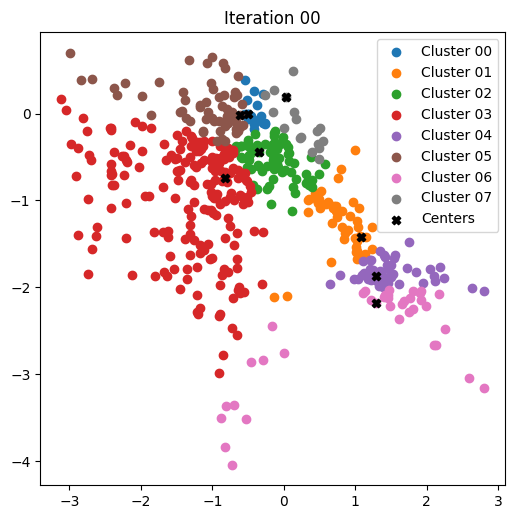

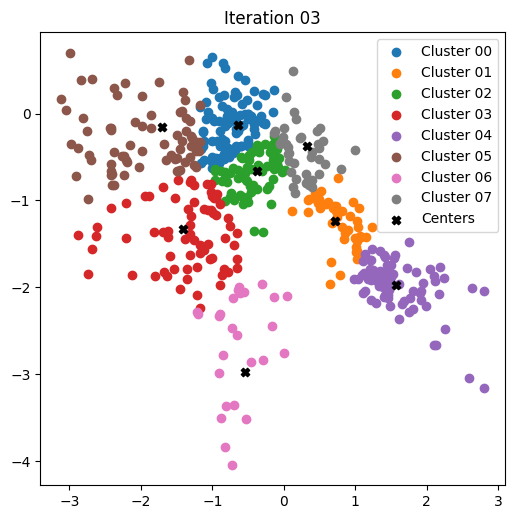

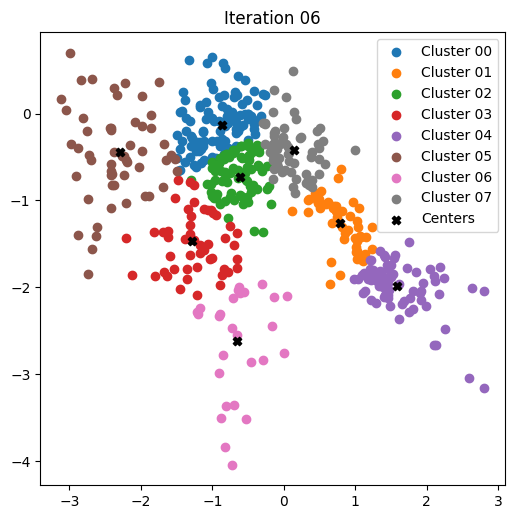

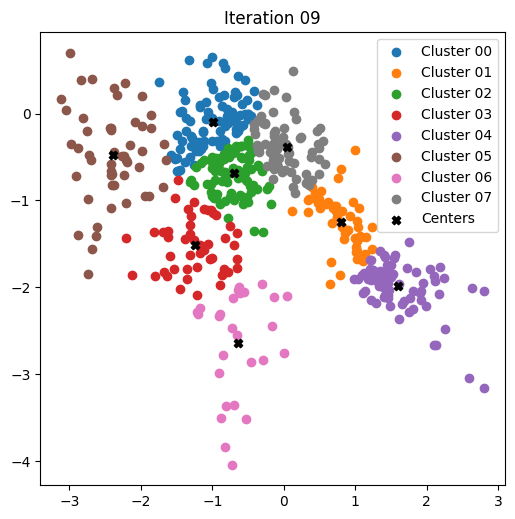

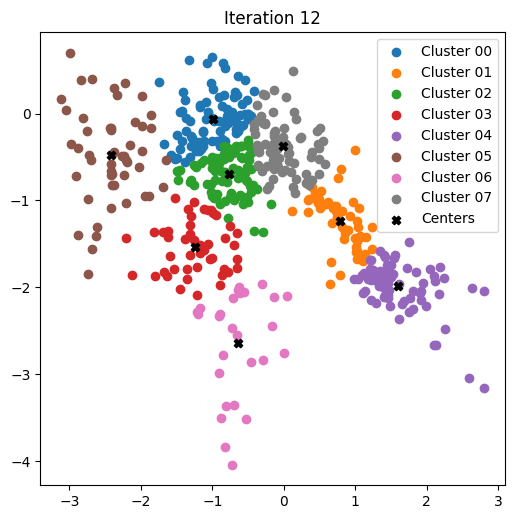

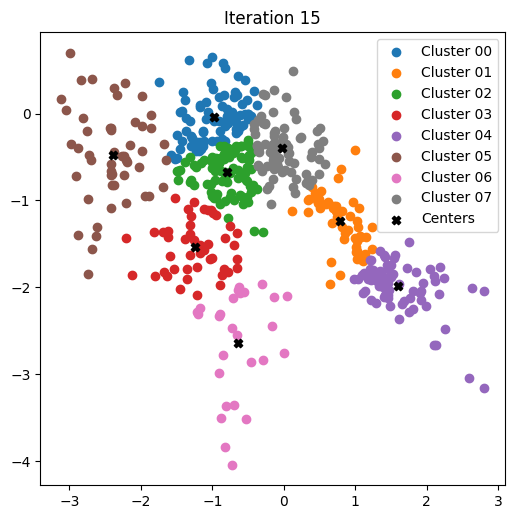

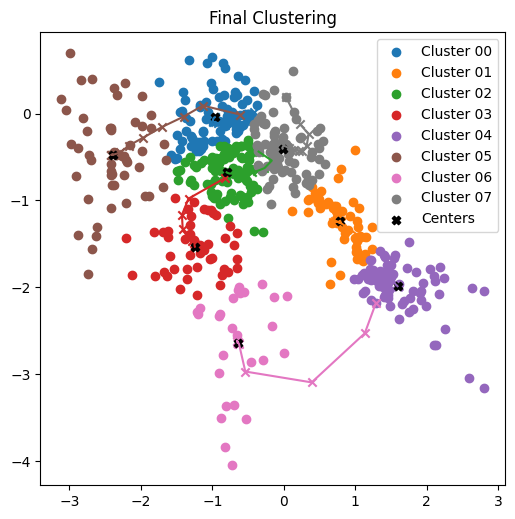

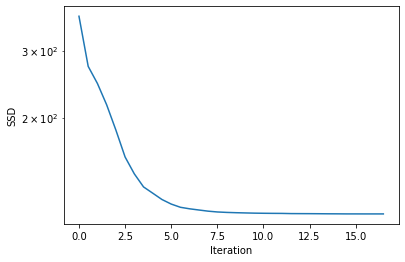

In [4]:

np.random.seed(42)

data = np.load("samples_3.npy")
k = 8

cluster_labels, centers, ssd_history, centers_history = k_means(data, k)

# plot final clustering with history of centers over iterations
visualize_2d_clustering(data, cluster_labels, centers, k=k, centers_history=centers_history, title="Final Clustering")

# plot SSD
plt.figure("SSD")
plt.semilogy(np.arange(start=0, stop=len(ssd_history) / 2, step=0.5), ssd_history)
plt.xlabel("Iteration")
plt.ylabel("SSD")
plt.show()

## 3.) Expectation Maximization for Gaussian Mixture Models (7 Points)

In the following we implement the Expectation Maximization (EM) Algorithm to fit a Gaussian Mixture Model (GMM) to data. We start with an implemenation for the log density of a single Gaussian (take some time to compare this implementation with the one used in the first exercies)... 

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

def gaussian_log_density(samples: np.ndarray, mean: np.ndarray, covariance: np.ndarray) -> np.ndarray:
    """
    Computes Log Density of samples under a Gaussian Distribution.
    We already saw an implementation of this in the first exercise and noted there that this was not the "proper"
    way of doing it. Compare the two implementations.
    :param samples: samples to evaluate (shape: [N x dim)
    :param mean: Mean of the distribution (shape: [dim])
    :param covariance: Covariance of the distribution (shape: [dim x dim])
    :return: log N(x|mean, covariance) (shape: [N])
    """
    dim = mean.shape[0]
    chol_covariance = np.linalg.cholesky(covariance)
    # Efficient and stable way to compute the log determinant and squared term efficiently using the cholesky
    logdet = 2 * np.sum(np.log(np.diagonal(chol_covariance) + 1e-25))
    # (Actually, you would use scipy.linalg.solve_triangular but I wanted to spare you the hustle of setting
    #  up scipy)
    chol_inv = np.linalg.inv(chol_covariance)
    exp_term = np.sum(np.square((samples - mean) @ chol_inv.T), axis=-1)
    return -0.5 * (dim * np.log(2 * np.pi) + logdet + exp_term)

... and some plotting functionaliy for 2D GMMs: 

In [3]:
def visualize_2d_gmm(samples, weights, means, covs, title):
    """Visualizes the model and the samples"""
    plt.figure(figsize=[7,7])
    plt.title(title)
    plt.scatter(samples[:, 0], samples[:, 1], label="Samples", c=next(plt.gca()._get_lines.prop_cycler)['color'])

    for i in range(means.shape[0]):
        c = next(plt.gca()._get_lines.prop_cycler)['color']

        (largest_eigval, smallest_eigval), eigvec = np.linalg.eig(covs[i])
        phi = -np.arctan2(eigvec[0, 1], eigvec[0, 0])

        plt.scatter(means[i, 0:1], means[i, 1:2], marker="x", c=c)

        a = 2.0 * np.sqrt(largest_eigval)
        b = 2.0 * np.sqrt(smallest_eigval)

        ellipse_x_r = a * np.cos(np.linspace(0, 2 * np.pi, num=200))
        ellipse_y_r = b * np.sin(np.linspace(0, 2 * np.pi, num=200))

        R = np.array([[np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)]])
        r_ellipse = np.array([ellipse_x_r, ellipse_y_r]).T @ R
        plt.plot(means[i, 0] + r_ellipse[:, 0], means[i, 1] + r_ellipse[:, 1], c=c,
                 label="Component {:02d}, Weight: {:0.4f}".format(i, weights[i]))
    plt.legend()

Now to the actual task: You need to implement 3 functions:
- the log likelihhod of a GMM for evaluation
- the E-Step of the EM algorithm for GMMs
- the M-Step of the EM algorithm for GMMs (for this one now for loops are allowed. Using them here will lead to point deduction)


All needed equations are in the slides 

In [73]:
def gmm_log_likelihood(samples: np.ndarray, weights: np.ndarray, means: np.ndarray, covariances: np.ndarray) -> float:
    """ Computes the Log Likelihood of samples given parameters of a GMM.
    :param samples: samples "x" to compute ess for    (shape: [N, dim])
    :param weights: weights (i.e., p(z) ) of old model (shape: [num_components])
    :param means: means of old components p(x|z) (shape: [num_components, dim])
    :param covariances: covariances of old components p(x|z) (shape: [num_components, dim, dim]
    :return: log likelihood
    """
    ############################################################
    # TODO Implement the log-likelihood for Gaussian Mixtures
    ############################################################
    return np.sum(weights[i]*gaussian_log_density(samples, means[i], covariances[i]) for i in range(len(weights)))


def e_step(samples: np.ndarray, weights: np.ndarray, means: np.ndarray, covariances: np.ndarray) -> np.ndarray:
    """ E-Step of EM for fitting GMMs. Computes estimated sufficient statistics (ess), p(z|x), using the old model from
    the previous iteration. In the GMM case they are often referred to as "responsibilities".
    :param samples: samples "x" to compute ess for    (shape: [N, dim])
    :param weights: weights (i.e., p(z) ) of old model (shape: [num_components])
    :param means: means of old components p(x|z) (shape: [num_components, dim])
    :param covariances: covariances of old components p(x|z) (shape: [num_components, dim, dim]
    :return: Responsibilities p(z|x) (Shape: [N x num_components])
    """
    ############################################################
    # TODO Implement the E-Step for EM for Gaussian Mixtrue Models.
    ############################################################
    N=samples.shape[0]
    num_components = len(weights)
    responsibilities = np.zeros((N,num_components))
    for i in range(N):
        divisor = gmm_log_likelihood(samples[i,:],weights,means,covariances)
        for k in range(num_components):
            responsibilities[i][k] = weights[k] * gaussian_log_density(samples[i,:],means[k],covariances[k]) / divisor
    return responsibilities


def m_step(samples: np.ndarray, responsibilities: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """ M-Step of EM for fitting GMMs. Computes new parameters given samples and responsibilities p(z|x)
    :param samples: samples "x" to fit model to (shape: [N, dim])
    :param responsibilities: p(z|x) (Shape: [N x num_components]), as computed by E-step
    :return: - new weights p(z) (shape [num_components])
             - new means of components p(x|z) (shape: [num_components, dim])
             - new covariances of components p(x|z) (shape: [num_components, dim, dim]
    """
    #########################################################
    # TODO: Implement the M-Step for EM for Gaussian Mixture models. You are not allowed to use any for loops!
    # Hint: Writing it directly without for loops is hard, especially if you are not experienced with broadcasting.
    # It's maybe easier to first implement it using for loops and then try getting rid of them, one after another.
    #########################################################

    summed_responsibilities = np.sum(responsibilities,axis=0)

    # 1. Update Coefficients
    weights = summed_responsibilities / responsibilities.shape[0]

    # 2. Update Components
    means = responsibilities.T @ samples / np.array([summed_responsibilities,summed_responsibilities]).T
    covariances = np.zeros((5,2,2))
    for k in range(responsibilities.shape[1]):
        diff = samples-means[k]
        covariances[k] = responsibilities[k] * diff.T @ diff / summed_responsibilities[k]

    return (weights,means,covariances)




We wrap out functions with the actual algorithm, iterating E and M step

In [74]:

def fit_gaussian_mixture(samples: np.ndarray, num_components: int, num_iters: int = 30, vis_interval: int = 5):
    """Fits a Gaussian Mixture Model using the Expectation Maximization Algorithm
    :param samples: Samples to fit the model to (shape: [N, dim]
    :param num_components: number of components of the GMM
    :param num_iters: number of iterations
    :param vis_interval: After how many iterations to generate the next plot
    :return: - final weights p(z) (shape [num_components])
             - final means of components p(x|z) (shape: [num_components, dim])
             - final covariances of components p(x|z) (shape: [num_components, dim, dim]
             - log_likelihoods: log-likelihood of data under model after each iteration (shape: [num_iters])
    """
    # Initialize Model: We initialize with means randomly picked from the data, unit covariances and uniform
    # component weights. This works here but in general smarter initialization techniques might be necessary, e.g.,
    # k-means
    initial_idx = np.random.choice(len(samples), num_components, replace=False)
    means = samples[initial_idx]
    covs = np.tile(np.eye(data.shape[-1])[None, ...], [num_components, 1, 1])
    weights = np.ones(num_components) / num_components

    # bookkeeping:
    log_likelihoods = np.zeros(num_iters)

    # iterate E and M Steps
    for i in range(num_iters):
        responsibilities = e_step(samples, weights, means, covs)
        weights, means, covs = m_step(samples, responsibilities)

        # Plotting
        if i % vis_interval == 0:
            visualize_2d_gmm(data, weights, means, covs, title="After Iteration {:02d}".format(i))

        print(gmm_log_likelihood(samples, weights, means, covs))
        log_likelihoods[i] = gmm_log_likelihood(samples, weights, means, covs)
    return weights, means, covs, log_likelihoods







Finally we load some data and run the algorithm. Feel free to play around with the parameters a bit. 

In [75]:
## ADAPTABLE PARAMETERS: 

np.random.seed(0)
num_components = 5
num_iters = 30
vis_interval = 5

# CHOOSE A DATASET
#data = np.load("samples_1.npy")
data = np.load("samples_2.npy")
#data = np.load("samples_3.npy")
#data = np.load("samples_u.npy")

# running and ploting
final_weights, final_means, final_covariances, log_likeihoods = \
    fit_gaussian_mixture(data, num_components, num_iters, vis_interval)
visualize_2d_gmm(data, final_weights, final_means, final_covariances, title="Final Model")

plt.figure()
plt.title("Log-Likelihoods over time")
plt.plot(log_likeihoods)
plt.xlabel("iteration")
plt.ylabel("log-likelihood")
plt.show()

div -4.163972316368392
div -4.057701925734139
div -9.434014328506798
div -4.700389899121221
div -13.269835410754158
div -11.49445581288774
div -6.990396721610663
div -4.156845263186829
div -6.715266623839113
div -4.965129649483395
div -3.872035122267498
div -4.801223814339305
div -8.253862630082024
div -5.970275472653504
div -5.01161281270265
div -8.208049938315716
div -4.731686550351263
div -4.847946807892131
div -4.21857524888517
div -4.34564882700542
div -4.2433610833156035
div -5.633039004469675
div -4.171021559668337
div -4.0297717817907115
div -4.013945672089889
div -10.4235117942198
div -4.369131043647172
div -4.680657575764462
div -4.2619380490678616
div -8.91094808366396
div -3.8921702879620996
div -5.33432482147623
div -7.101541198415244
div -5.609038819332939
div -8.401509323318528
div -3.9840999019259886
div -8.999601991436615
div -4.02214571682099
div -5.018303045034983
div -4.701556082519908
div -4.224785866309281
div -4.171740899745088
div -4.928609614920779
div -4.08033

ValueError: operands could not be broadcast together with shapes (5,) (2,500) 